# 1. VQ-VAE

1) Import Libraries

In [2]:
# VQ-VAE.ipynb
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import torch
from torchvision import datasets
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import os 

#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2) CUDA Setting

In [4]:
# CUDA setting
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"CUDA GPU : {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')

CUDA GPU : NVIDIA GeForce RTX 4070 Ti SUPER


3) Dataset Download & Parse

In [5]:
import os
os.chdir('./3. Vector Quantized Variational Autoencoder/')

In [6]:
# Dataset download (MNIST)

BATCH_SIZE = 512

train_data = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
test_data =  datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_loader =  torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

4) Model Architecture & Structure - VQ Part

In [19]:
class VectorQuantizer(nn.Module):
    def __init__(self, latent_dimension = 8, codebook_size = 16, beta = 0.25) -> None:
        super(VectorQuantizer, self).__init__()

        self.latent_dimension = latent_dimension
        self.codebook_size = codebook_size

        self.codebook = nn.Embedding(num_embeddings=self.codebook_size, embedding_dim=self.latent_dimension) #work as embedding layer
        self.codebook.weight.data.uniform_(-1/self.codebook_size, 1/self.codebook_size)

        self.beta = beta

    def forward(self, input):
        # BCHW -> BHWC
        input = input.permute(0, 2, 3, 1).contiguous()
        input_shape = input.shape

        # Flatten
        flat_input = input.view(-1, self.latent_dimension)

        # Calculate dist
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self.codebook.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self.codebook.weight.t()))
        
        # Encode
        Encoded_vec = torch.zeros([flat_input.shape[0], self.codebook_size], device=input.device)
        idxs = torch.argmin(distances, dim=1).unsqueeze(1)
        Encoded_vec = Encoded_vec.scatter_(1, idxs, 1)
        
        # Matmul
        quantized_vec = torch.matmul(Encoded_vec, self.codebook.weight).view(input_shape)

        # Loss function
        quantization_loss = F.mse_loss(input=quantized_vec, target=input.detach())
        commitment_loss = F.mse_loss(input=quantized_vec.detach(), target=input)

        loss = quantization_loss + self.beta * commitment_loss

        # Pass through !!
        quantized_vec = input + (quantized_vec - input).detach()
    
        # BHWC -> BCHW
        quantized_vec = quantized_vec.permute(0, 3, 1, 2).contiguous()

        # print(perplexity)
        return quantized_vec, loss

#VQ = VectorQuantizer().to(device)
#VQ(torch.randn([20, 8, 1, 1]).to(device))

4. Model Architecture & Structure - VAE Part

In [20]:
# Model Architecture

class VQVAE(nn.Module):
    def __init__(self, latent_dimension=8, codebook_size=16):
        super(VQVAE, self).__init__()

        self.latent_dimension = latent_dimension
        self.codebook_size = codebook_size

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1), # 1x28x28 -> 32x14x14
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1), # 32x14x14 -> 64x7x7
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7), # 64x7x7 -> 64x1x1
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=7),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

        self.VectorQuantizer = VectorQuantizer().to(device)

    def forward(self, x):
        encoded_x = self.encoder(x)
        latent_x, loss = self.VectorQuantizer(encoded_x)

        recon_x = self.decoder(latent_x)
        
        return recon_x, loss, encoded_x


5) Training defined model (dimension = 16)

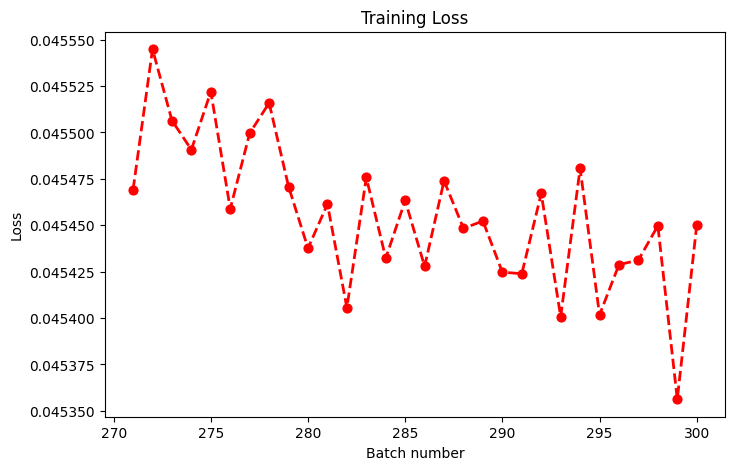

100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [06:04<00:00,  1.22s/it]


In [21]:
from IPython import display

model = VQVAE().to(device)
model.train()

learning_rate = 7E-4
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch = 300
losses = list()

for epoch_idx in trange(epoch):

    running_loss = 0.0
    total_batches = 0

    for (X, y) in train_loader:
        X = X.to(device)

        res, loss, perplex = model(X)

        recon_loss = F.mse_loss(res, X)
        total_loss = recon_loss + loss

        running_loss += (loss.item() + recon_loss.item())
        total_batches += 1

        optim.zero_grad()
        total_loss.backward()
        optim.step()
    
    losses.append(running_loss / total_batches)

    display.clear_output(wait=True)
    plt.figure(figsize=(8, 5))

    xrange = [i for i in range(1, epoch_idx+2)]
    if len(xrange) > 30:
        xrange = xrange[-30:]
        yrange = losses[xrange[0]-1:xrange[-1]]
    else:
        yrange = losses[:]
    
    plt.plot(xrange,yrange, linestyle='--', linewidth=2, c='r')
    plt.scatter(xrange, yrange, c='red', s=40)
    plt.xlabel('Batch number')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

6) Visualization of my model

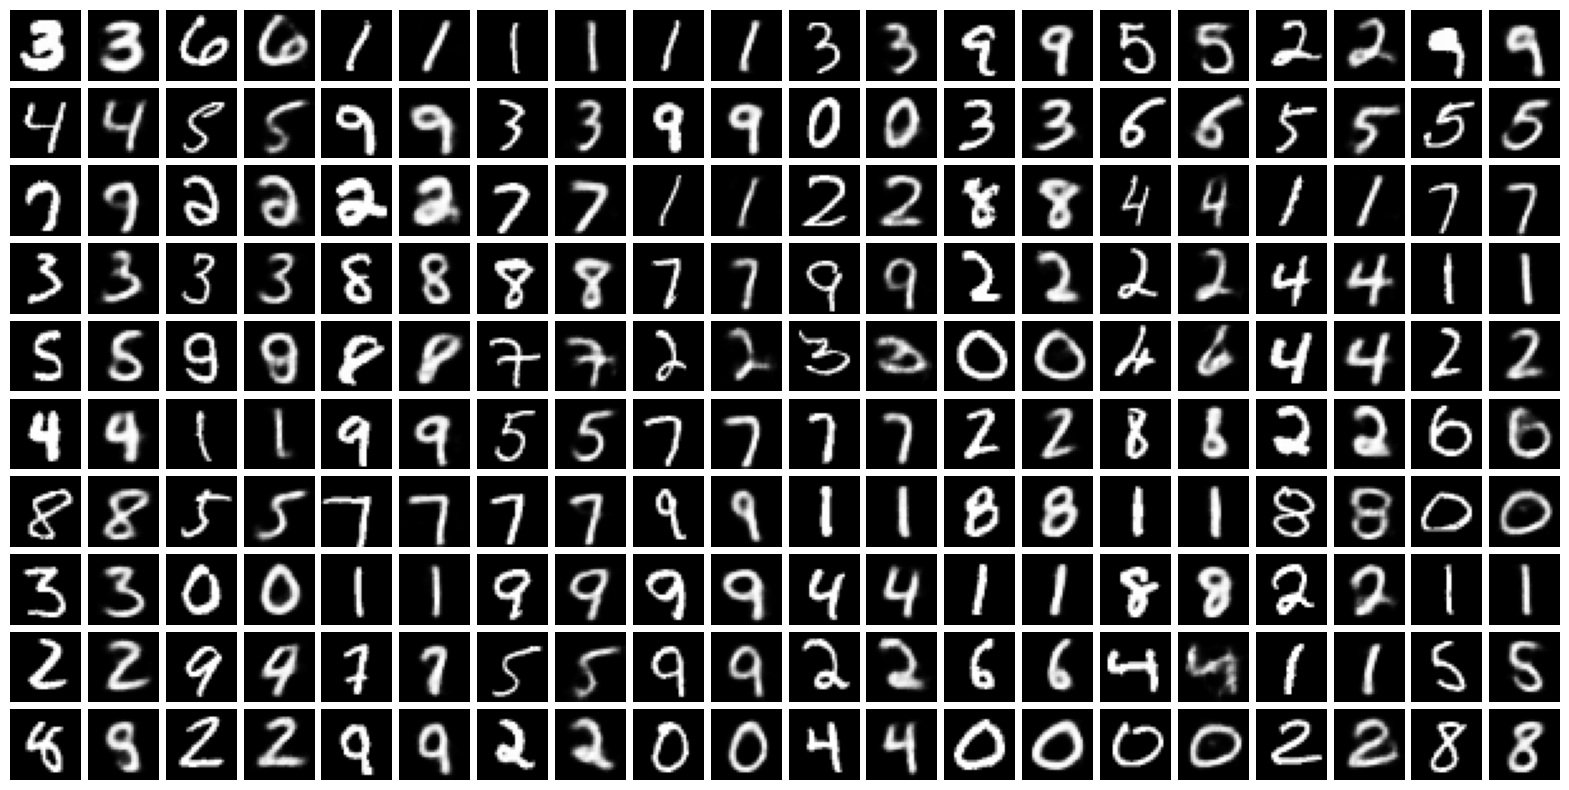

In [22]:
import matplotlib.pyplot as plt
import torch

# model = torch.load('./VQVAE_MNIST.pt', map_location=device)

start_idx = 200
num_pairs = 100
pairs_per_row = 10

plt.figure(figsize=(20, 10))

for i in range(num_pairs):
    row = i // pairs_per_row
    col = i % pairs_per_row

    # Original Image
    plt.subplot(10, 20, 2 * col + 1 + 20 * row)
    data = test_data[start_idx + i][0]
    img = data.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    # Reconstructed Image
    plt.subplot(10, 20, 2 * col + 2 + 20 * row)
    with torch.no_grad():
        reconstructed_images, _, __ = model(data.unsqueeze(0).to(device))
    reconstructed_images = reconstructed_images.cpu()
    plt.imshow(reconstructed_images.squeeze().reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


7) Saving Model Weights

In [23]:
torch.save(model, "./VQVAE_MNIST.pt")
losses[-1]

0.045450015877515584

## 2. 2D Modeling (decomposition)

In [24]:
from sklearn.manifold import TSNE

model = torch.load("./VQVAE_MNIST.pt", map_location=device)
codebook = model.VectorQuantizer.codebook.weight.cpu().detach().numpy()


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 676.41it/s]


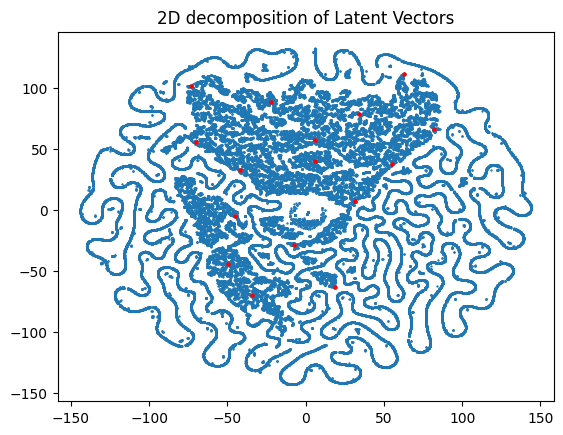

In [35]:
model.eval()

latent_vectors = []
label = []
colors = ['#fe7c73', '#2471A3', '#3498DB', '#27AE60', '#82E0AA', '#D35400', '#5D6D7E', '#E74C3C', '#21618C', '#B7950B']

for (X, y) in tqdm(test_data):
    X = X.to(device).unsqueeze(0)
    recon_x, loss, latent_x = model(X)
    latent_vectors.append(latent_x.view(8,8).detach().cpu().numpy())

all_latent_vectors = np.vstack(latent_vectors)
all_latent_vectors = np.vstack([all_latent_vectors, model.VectorQuantizer.codebook.weight.detach().cpu().numpy()])

decomposition_model = TSNE(n_components=2)
latent_2d = decomposition_model.fit_transform(all_latent_vectors)

plt.scatter(latent_2d[:, 0][:-16], latent_2d[:, 1][:-16], s=0.5)
plt.scatter(latent_2d[:, 0][-16:], latent_2d[:, 1][-16:], s=5, c='red')

plt.title('2D decomposition of Latent Vectors')
plt.show()